## Import the libraries

In [1]:
import pandas as pd
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

## Exploratory Data Analysis

In [2]:
dataset_path = 'data/'

df_original = pd.read_csv(os.path.join(dataset_path, 'train.csv'))

print("The shape of the dataset is {}.\n\n".format(df_original.shape))

df_original.head()

The shape of the dataset is (6407, 16).




,ID,Lat,Lng,Bump,Distance(mi),Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Stop,Amenity,Side,Severity,timestamp
0,0,37.762150,-122.405660,False,0.044,False,False,False,False,False,False,False,True,R,2,2016-03-25 15:13:02
1,1,37.719157,-122.448254,False,0.000,False,False,False,False,False,False,False,False,R,2,2020-05-05 19:23:00
2,2,37.808498,-122.366852,False,0.000,False,False,False,False,False,False,True,False,R,3,2016-09-16 19:57:16
3,3,37.785930,-122.391080,False,0.009,False,False,True,False,False,False,False,False,R,1,2020-03-29 19:48:43
4,4,37.719141,-122.448457,False,0.000,False,False,False,False,False,False,False,False,R,2,2019-10-09 08:47:00


In [3]:
def create_datetime_cols(df_original):
    """
    Convert 'timestamp' column to datetime and split it to date and time features, inplace
    """
    df = df_original.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['Date'] = df['timestamp'].dt.strftime('%d.%m.%Y')
    df['Year'] = pd.DatetimeIndex(df['timestamp']).year
    df['Month'] = pd.DatetimeIndex(df['timestamp']).month
    df['Day'] = pd.DatetimeIndex(df['timestamp']).day
    df['Hour'] = pd.DatetimeIndex(df['timestamp']).hour
    df['Date_hour'] = pd.to_datetime(df[['Year', 'Month', "Day", "Hour"]])
    
    return df

df = create_datetime_cols(df_original)

## Load xml holidays data

In [4]:
import xml.etree.ElementTree as et
def get_XML_df(xml_file, df_cols=["date", "description"]): 
    """
    Parse the input XML file and store the result in a pandas DataFrame with the given columns. 
    Date and time features are also created and split as done with the train and validation data set.
    """
    
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    rows = []    
    
    for node in xroot: 
        date = node.find(df_cols[0]).text if node is not None else None
        description = node.find(df_cols[1]).text if node is not None else None
        
        rows.append({df_cols[0]: date, df_cols[1]: description})
    
    df_xml = pd.DataFrame(rows, columns=df_cols)
    df_xml['Date'] = pd.to_datetime(df_xml['date'])
    df_xml['Year'] = pd.DatetimeIndex(df_xml['Date']).year
    df_xml['Month'] = pd.DatetimeIndex(df_xml['Date']).month
    df_xml['Day'] = pd.DatetimeIndex(df_xml['Date']).day
    df_xml.drop(columns=["date"], inplace=True)
        
    return df_xml

def add_is_holiday(df, df_xml):
    df['is_holiday'] = df['Date'].apply(lambda date: date in df_xml['Date'])

In [5]:
df_xml = get_XML_df("data/holidays.xml", ["date", "description"])
add_is_holiday(df, df_xml)
df.head()
df.shape

(6407, 23)

## Load and prepare Weather data

In [6]:
# Loading weather condition
df_weather = pd.read_csv(os.path.join(dataset_path, 'weather-sfcsv.csv'))
df_weather.drop(columns='Selected', inplace=True)

## Impute Missing Data

In [7]:
# Impute missing data in Wind Speed feature
from sklearn.impute import KNNImputer
def impute_windspeed(df_weather):
    # Drop all nulls using all features except Wind_Speed(mph)
    df_imputed = df_weather.dropna(subset=df_weather.columns.difference(['Wind_Speed(mph)'])).copy()

    # Encode Weather_Condition column
    df_imputed = pd.get_dummies(df_imputed, columns=['Weather_Condition'], drop_first='True', prefix='Weather_Condition')
    # Create KNNImputer object
    imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    df_imputed = pd.DataFrame(imputer.fit_transform(df_imputed), columns=df_imputed.columns)
    df_weather['Wind_Speed(mph)'] = df_imputed['Wind_Speed(mph)']
    
impute_windspeed(df_weather)

## Clean Weather data


In [8]:
# Create a Date_hour column to use in merging later
df_weather['Date_hour'] = pd.to_datetime(df_weather[['Year', 'Month', "Day", "Hour"]])
# Keep Relevant columns with unbiased values
df_weather = df_weather.loc[:, df_weather.columns.isin(['Date_hour', 'Weather_Condition', 'Wind_Speed(mph)'])]
df_weather.dropna(inplace=True)

# Unite all values with the word "Cloud.*"
df_weather['Weather_Condition'] = df_weather['Weather_Condition'].apply(lambda val : val.replace(val, "Cloudy") if "Cloud" in val else val)


# Remove duplicated rows
df_weather = df_weather.loc[~df_weather.duplicated('Date_hour'), :]

In [9]:
# Merge both datasets
def merge_with_weather(df, df_weather):
    df = pd.merge(df, df_weather, how='left', on='Date_hour')
    df.drop(columns='Date_hour', inplace=True)
    return df

df = merge_with_weather(df, df_weather)
df.head()

,ID,Lat,Lng,Bump,Distance(mi),Crossing,Give_Way,Junction,No_Exit,Railway,...,Severity,timestamp,Date,Year,Month,Day,Hour,is_holiday,Weather_Condition,Wind_Speed(mph)
0,0,37.762150,-122.405660,False,0.044,False,False,False,False,False,...,2,2016-03-25 15:13:02,25.03.2016,2016,3,25,15,False,Cloudy,14.0
1,1,37.719157,-122.448254,False,0.000,False,False,False,False,False,...,2,2020-05-05 19:23:00,05.05.2020,2020,5,5,19,False,NaN,NaN
2,2,37.808498,-122.366852,False,0.000,False,False,False,False,False,...,3,2016-09-16 19:57:16,16.09.2016,2016,9,16,19,False,NaN,NaN
3,3,37.785930,-122.391080,False,0.009,False,False,True,False,False,...,1,2020-03-29 19:48:43,29.03.2020,2020,3,29,19,False,Fair,18.0
4,4,37.719141,-122.448457,False,0.000,False,False,False,False,False,...,2,2019-10-09 08:47:00,09.10.2019,2019,10,9,8,False,NaN,NaN


## Encode Features

In [10]:
def encode_features(df):
    """Encode all bool and categorical columns in the dataset"""
    # Rename dataframe
    df_encoded = df

    # Add a feature is_holiday based on xml data
    df_encoded.drop(columns=['timestamp'], inplace=True)
    df_encoded.drop(columns='Date', inplace=True)

    # Fetch boolean columns' names
    bool_columns = df_encoded.select_dtypes(include='bool').columns
    # Encode them to 0 and 1
    df_encoded[bool_columns] = df_encoded[bool_columns].astype('int')

    # Encode the "side" value to 0 and 1 for "L" and "R", respectively
    df_encoded.replace({'Side': {'L': 0, 'R': 1}}, inplace=True)
    
    # Encode features from weather dataset
    df_encoded = pd.get_dummies(df, columns=['Weather_Condition'], drop_first='True', prefix='Weather_Condition')
    
    return df_encoded

df = encode_features(df)
df.shape

(6407, 35)

## Chi-Square test
Use Chi-square independence test to determine which features to keep

In [11]:
# df_eda = df[df['Severity'].isin([1, 4])]
df_eda = df.copy()
df_eda = df_eda.select_dtypes(exclude='float64')
df_eda.drop(columns=["ID"], inplace=True)
#Performing Chi-Square, test of independence
from scipy.stats import chi2_contingency
from scipy.stats import chi2

def independence_test(table):
    # interpret test-statistic
    stat, p, dof, expected = chi2_contingency(table)
    # interpret p-value
    alpha = 0.05
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
        
for col_name, col_val in df_eda.iteritems():
    table = pd.crosstab(index=df_eda['Severity'], columns=col_val)
    print(table)
    print('Testing Dependency ', col_name)
    independence_test(table)
    print('')


Bump         0
Severity      
1          129
2         4346
3         1855
4           77
Testing Dependency  Bump
Independent (fail to reject H0)

Crossing     0    1
Severity           
1          120    9
2         3898  448
3         1794   61
4           67   10
Testing Dependency  Crossing
Dependent (reject H0)

Give_Way     0  1
Severity         
1          129  0
2         4343  3
3         1855  0
4           77  0
Testing Dependency  Give_Way
Independent (fail to reject H0)

Junction     0     1
Severity            
1           50    79
2         3266  1080
3         1459   396
4           53    24
Testing Dependency  Junction
Dependent (reject H0)

No_Exit      0  1
Severity         
1          129  0
2         4345  1
3         1855  0
4           77  0
Testing Dependency  No_Exit
Independent (fail to reject H0)

Railway      0    1
Severity           
1          126    3
2         4209  137
3         1830   25
4           72    5
Testing Dependency  Railway
Dependent (reje

In [12]:
def clean_data(df):
    """Function drops unwanted or biased features and null values"""
    df.drop(list(df.filter(regex = '^(?!.+(Fair|Overcast)$)^Weather_Condition_.*$')), axis = 1, inplace = True)
    df.drop(columns=[
        'No_Exit', 'Bump', 'Roundabout', 'is_holiday', 
        "Give_Way", 'Wind_Speed(mph)'
    ], inplace=True)
    df.dropna(inplace=True)
    
clean_data(df)

## Data Splitting

In [13]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Severity']) # Try adding `stratify` here

X_train = train_df.drop(columns=['ID', 'Severity'])
y_train = train_df['Severity']

X_val = val_df.drop(columns=['ID', 'Severity'])
y_val = val_df['Severity']

## Model Training
As per the competition's rules, the hyperparameter `max_depth` is set to `2` 

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Create an instance of the classifier
classifier = RandomForestClassifier(max_depth=2, random_state=0)

# Train the classifier
classifier = classifier.fit(X_train, y_train)

Test the classifier on the validation dataset and check accuracy.

In [15]:
unique_elements, counts_elements = np.unique(classifier.predict(X_val), return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))
print("The accuracy of the classifier on the validation set is ", (classifier.score(X_val, y_val)))

Frequency of unique values of the said array:
[[   2    3]
 [1185   97]]
The accuracy of the classifier on the validation set is  0.7464898595943837


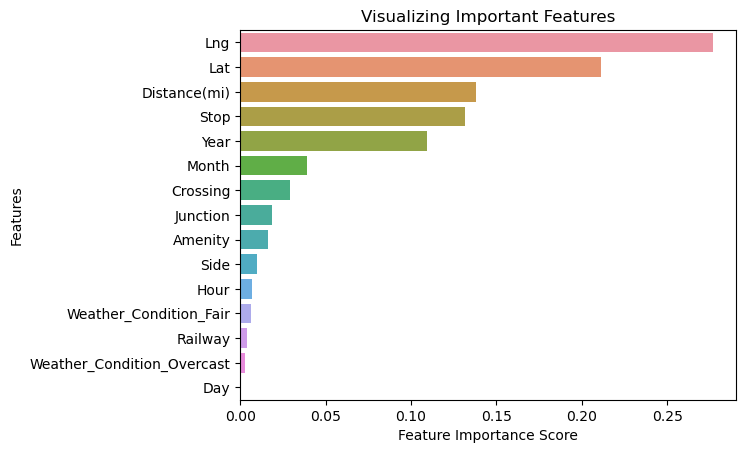

In [16]:
#Find most important features to the model
import seaborn as sns
import matplotlib.pyplot as plt
feature_imp = pd.Series(classifier.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)

plt.rcParams['figure.figsize'] = [18, 6]
plt.rcParams['figure.dpi'] = 100

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()